### Clustering of words based on UMAP and sbert
[sbert](https://www.sbert.net/)
[UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)

In [140]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [141]:
defFile1 = "primitiveDef.json"
defFile2 = "skillDef.json"
defFile3 = "taskDef.json"

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile1)) as json_file:
    defWord1 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile2)) as json_file:
    defWord2 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile3)) as json_file:
    defWord3 = json.load(json_file)


defWord = defWord1 + defWord2 + defWord3

print(len(defWord))

555


### Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [142]:
# remove duplicates
defSing = [word for word in list(set(defWord)) if type(word) is str]

print(len(defSing))

332


In [143]:
from sentence_transformers import SentenceTransformer

# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2') # SentenceTransformer('all-mpnet-base-v2')
sentence_embeddings = model.encode(defSing)
sentence_embeddings.shape

(332, 768)

### Clustering
We now follow the guide of topic modelling, [guide](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

In [144]:
n_neighbors=7
n_components=2

import umap
umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=n_components, 
                            metric='cosine').fit_transform(sentence_embeddings)

In [145]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

18


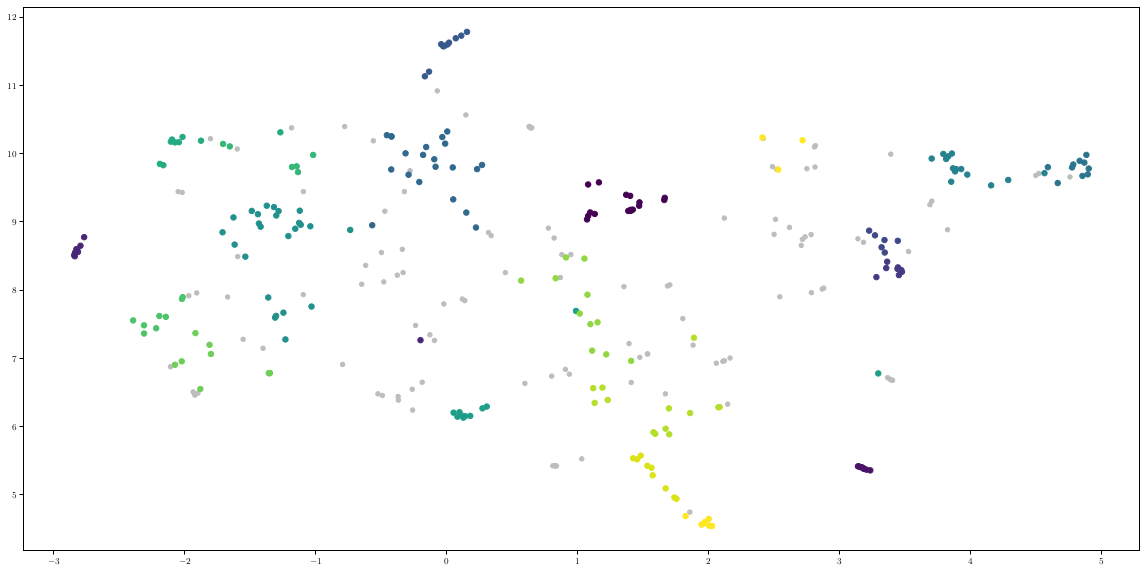

In [146]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

#print(result)

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print(max(result.labels))
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=20)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=30, cmap='viridis')
#plt.colorbar()

In [150]:
d = {'primitive': defSing, 'cluster':result['labels'], 'x': result['x'], 'y': result['y']}

clusterDF = pd.DataFrame(d)
clusterDF['Doc_ID'] = range(len(clusterDF))

primitivesPerTopic = clusterDF.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

    cluster                                          primitive
0        -1  collision handle open use hand detect and trac...
1         0  translate flip re orient rotate spin back disp...
2         1  compare compare colour compare position compar...
3         2  screw nut start screw driver start tool turn s...
4         3  compliant control function arm to zero hand mo...
5         4  free motion movement trajectory velocity motio...
6         5  actuate gripper gripper action grip on grip gr...
7         6  remove drink wipe drop release separation put ...
8         7  move  ptp big move worker move lin move move t...
9         8  navigation edge transition navigate guide move...
10        9  stick fasten push close press in apply force i...
11       10  inspect quality bimanual replace the tray asse...
12       11  manipulation and handle grasp and screw grasp ...
13       12                pick up hold call carry pickup pull
14       13  drill hole peg in hole operations counters

As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea) we get the most recurring keywords for each cluster

In [191]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

#group by cluster
groups = clusterDF.groupby('cluster')

labels = []

# extract keys from groups
keys = groups.groups.keys()

for i in keys:
    mean = np.array((float(groups.get_group(i)['x'].mean()), float(groups.get_group(i)['y'].mean())))
    maxDst = 0
    candidate_word = ""

    for index, row in groups.get_group(i).iterrows():
        pt = np.array((float(row['x']), float(row['y'])))
        dst = distance.euclidean(mean, pt)
        if dst > maxDst:
            maxDst = dst
            candidate_word = row['primitive']
    
    print("GROUP NR: " + str(row['cluster']))
    print("GROUP DST: " + candidate_word)

    labels.append(candidate_word)

# # group by "X" column
# groups = primitivesPerTopic.groupby('cluster')
  
# labels = []

# # extract keys from groups
# keys = groups.groups.keys()

# for i in keys:

#     groups.get_group(i)

#     n_gram_range = (1, 1)
#     stop_words = "english"

#     # Extract candidate words/phrases
#     count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(groups.get_group(i)['primitive'])
#     candidates = count.get_feature_names()

#     model = SentenceTransformer('all-mpnet-base-v2') # msmarco-distilbert-base-tas-b
#     doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
#     candidate_embeddings = model.encode(candidates)

#     top_n = 2
#     distances = cosine_similarity(doc_embedding, candidate_embeddings)
#     keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

    

#     print("GROUP: " + str(i))
    
#     #print(keywords)

#     matchedKeywords = str(keywords[0] + "-" + keywords[1])
#     print(matchedKeywords)

    
#     labels.append(matchedKeywords)

    # need to add names to each of the group for visualization

GROUP NR: -1
GROUP DST: ptp move
GROUP NR: 0
GROUP DST: displace
GROUP NR: 1
GROUP DST: compare weight
GROUP NR: 2
GROUP DST: start tool
GROUP NR: 3
GROUP DST: posture control
GROUP NR: 4
GROUP DST: trajectory
GROUP NR: 5
GROUP DST: grip on
GROUP NR: 6
GROUP DST: put
GROUP NR: 7
GROUP DST: big move worker
GROUP NR: 8
GROUP DST: move relative
GROUP NR: 9
GROUP DST: bond
GROUP NR: 10
GROUP DST: machine tend
GROUP NR: 11
GROUP DST: manipulation and handle
GROUP NR: 12
GROUP DST: pick up
GROUP NR: 13
GROUP DST: peg in hole
GROUP NR: 14
GROUP DST: burr removal
GROUP NR: 15
GROUP DST: object train
GROUP NR: 16
GROUP DST: pose
GROUP NR: 17
GROUP DST: pick and place operation
GROUP NR: 18
GROUP DST: secure


In [192]:
# By knowing the names extracted from the clusters we can then assign them to the clusterDF which can plot the scatter plot
labelsLong = []
clusterDF["keyword"] = ""

for idx, row in clusterDF.iterrows(): 

    for i in range(len(labels)):
        if clusterDF.iloc[idx]["cluster"] == (i-1):
            clusterDF.at[idx, 'keyword'] = labels[i]
            #print(clusterDF.iloc[idx]["keyword"])

print(max(clusterDF["cluster"]))
print(min(clusterDF["x"]))
print(max(clusterDF["x"]))
print(min(clusterDF["y"]))
print(max(clusterDF["y"]))

18
-2.8455989360809326
4.902914047241211
4.543303966522217
11.783940315246582


C:\Users\z0040kve\AppData\Local\Temp/ipykernel_17524/352232466.py:68: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


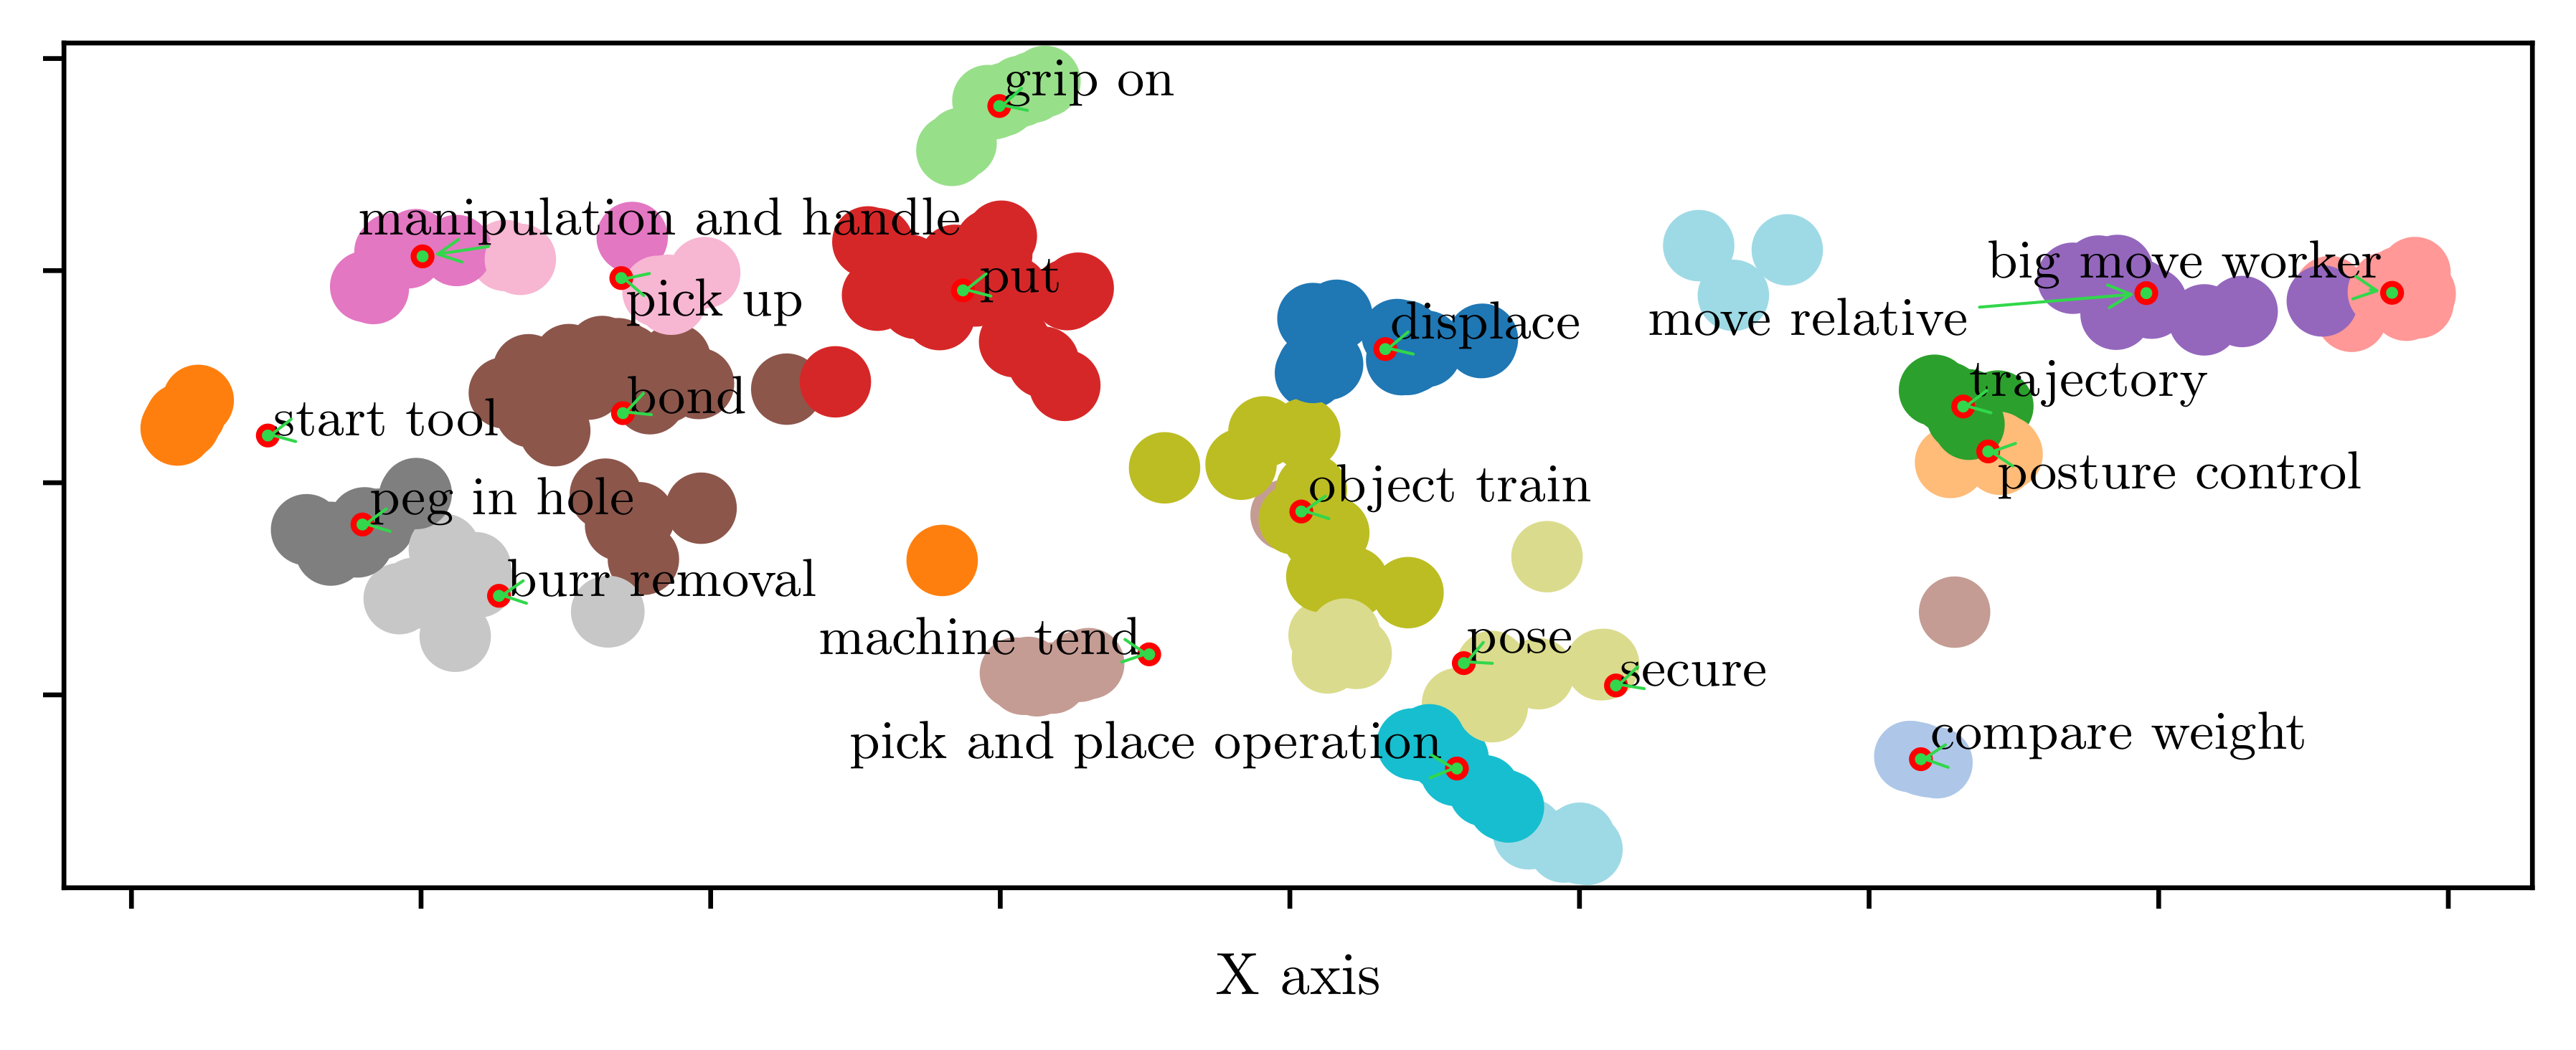

In [193]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from adjustText import adjust_text # to avoid overlapping text

# Latex export
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Visualize clusters with most appearing keywords
# (20,10)
fig, ax = plt.subplots(figsize=(7.4, 2.6), dpi=600)
outliers = clusterDF.loc[clusterDF.cluster == -1, :]
clustered = clusterDF.loc[clusterDF.cluster != -1, :]
plt.rcParams.update({'font.size': 9.5})
#pri

#plt.figure(figsize=(3240/600, 1280/600), dpi=600)

#plt.scatter(outliers.x, outliers.y, color='#F2F2F2', s=30)
plt.scatter(clustered.x, clustered.y, c=clustered.cluster, s=120, cmap='tab20')
#plt.colorbar()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#loop through labels and plot each cluster

# group by "X" column
groups = clustered.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()
texts = []

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()
    
    
    plt.plot(x, y, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="#32d74b")
    #plt.annotate(groups.get_group(i).iloc[0]["keyword"], xy = (x,y))
    texts.append(plt.text(x, y, groups.get_group(i).iloc[0]["keyword"]))

#plt.xticks(color='w')
#plt.yticks(color='w')

plt.xlabel("X axis", fontsize=10)

#visualiplt.ylabel("Dimension 2", fontsize=10)

# import tikzplotlib

# tikzplotlib.save("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.tex")
#plt.plot([6.5, 6.5], [8, 14], color='#32d74b', linestyle='--', linewidth=0.6)
#plt.plot([2, 9], [11, 11], color='#32d74b', linestyle='--', linewidth=0.6)
# adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
adjust_text(texts, only_move={'points':'x','texts':'y','objects':'x'})#, arrowprops=dict(arrowstyle="->", color='#32d74b', lw=0.5))
#plt.plot([3, 11], [10.5, 10.5], color='#8A8AFF', linestyle='--', linewidth=1)

plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.pgf', dpi=600, bbox_inches = 'tight')
plt.show()

Here we want to perform hiererchical clustering without outliers

In [ ]:
embd_list = []

for i in range(len(sentence_embeddings)):
    embd_list.append(i)

print(len(sentence_embeddings))
print(len(embd_list))

d = {'primitive':clusterDF['primitive'].to_list(),'cluster':clusterDF['cluster'].to_list(), 'embedding': embd_list}

clustersEmbeddings = pd.DataFrame(d)

clusteredEmb = clustersEmbeddings.loc[clustersEmbeddings.cluster != -1, :]

CLUSTEREDsentence_embeddings =  np.array(sentence_embeddings)[clusteredEmb['embedding'].to_list()]   

332
332


In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = CLUSTEREDsentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))

239


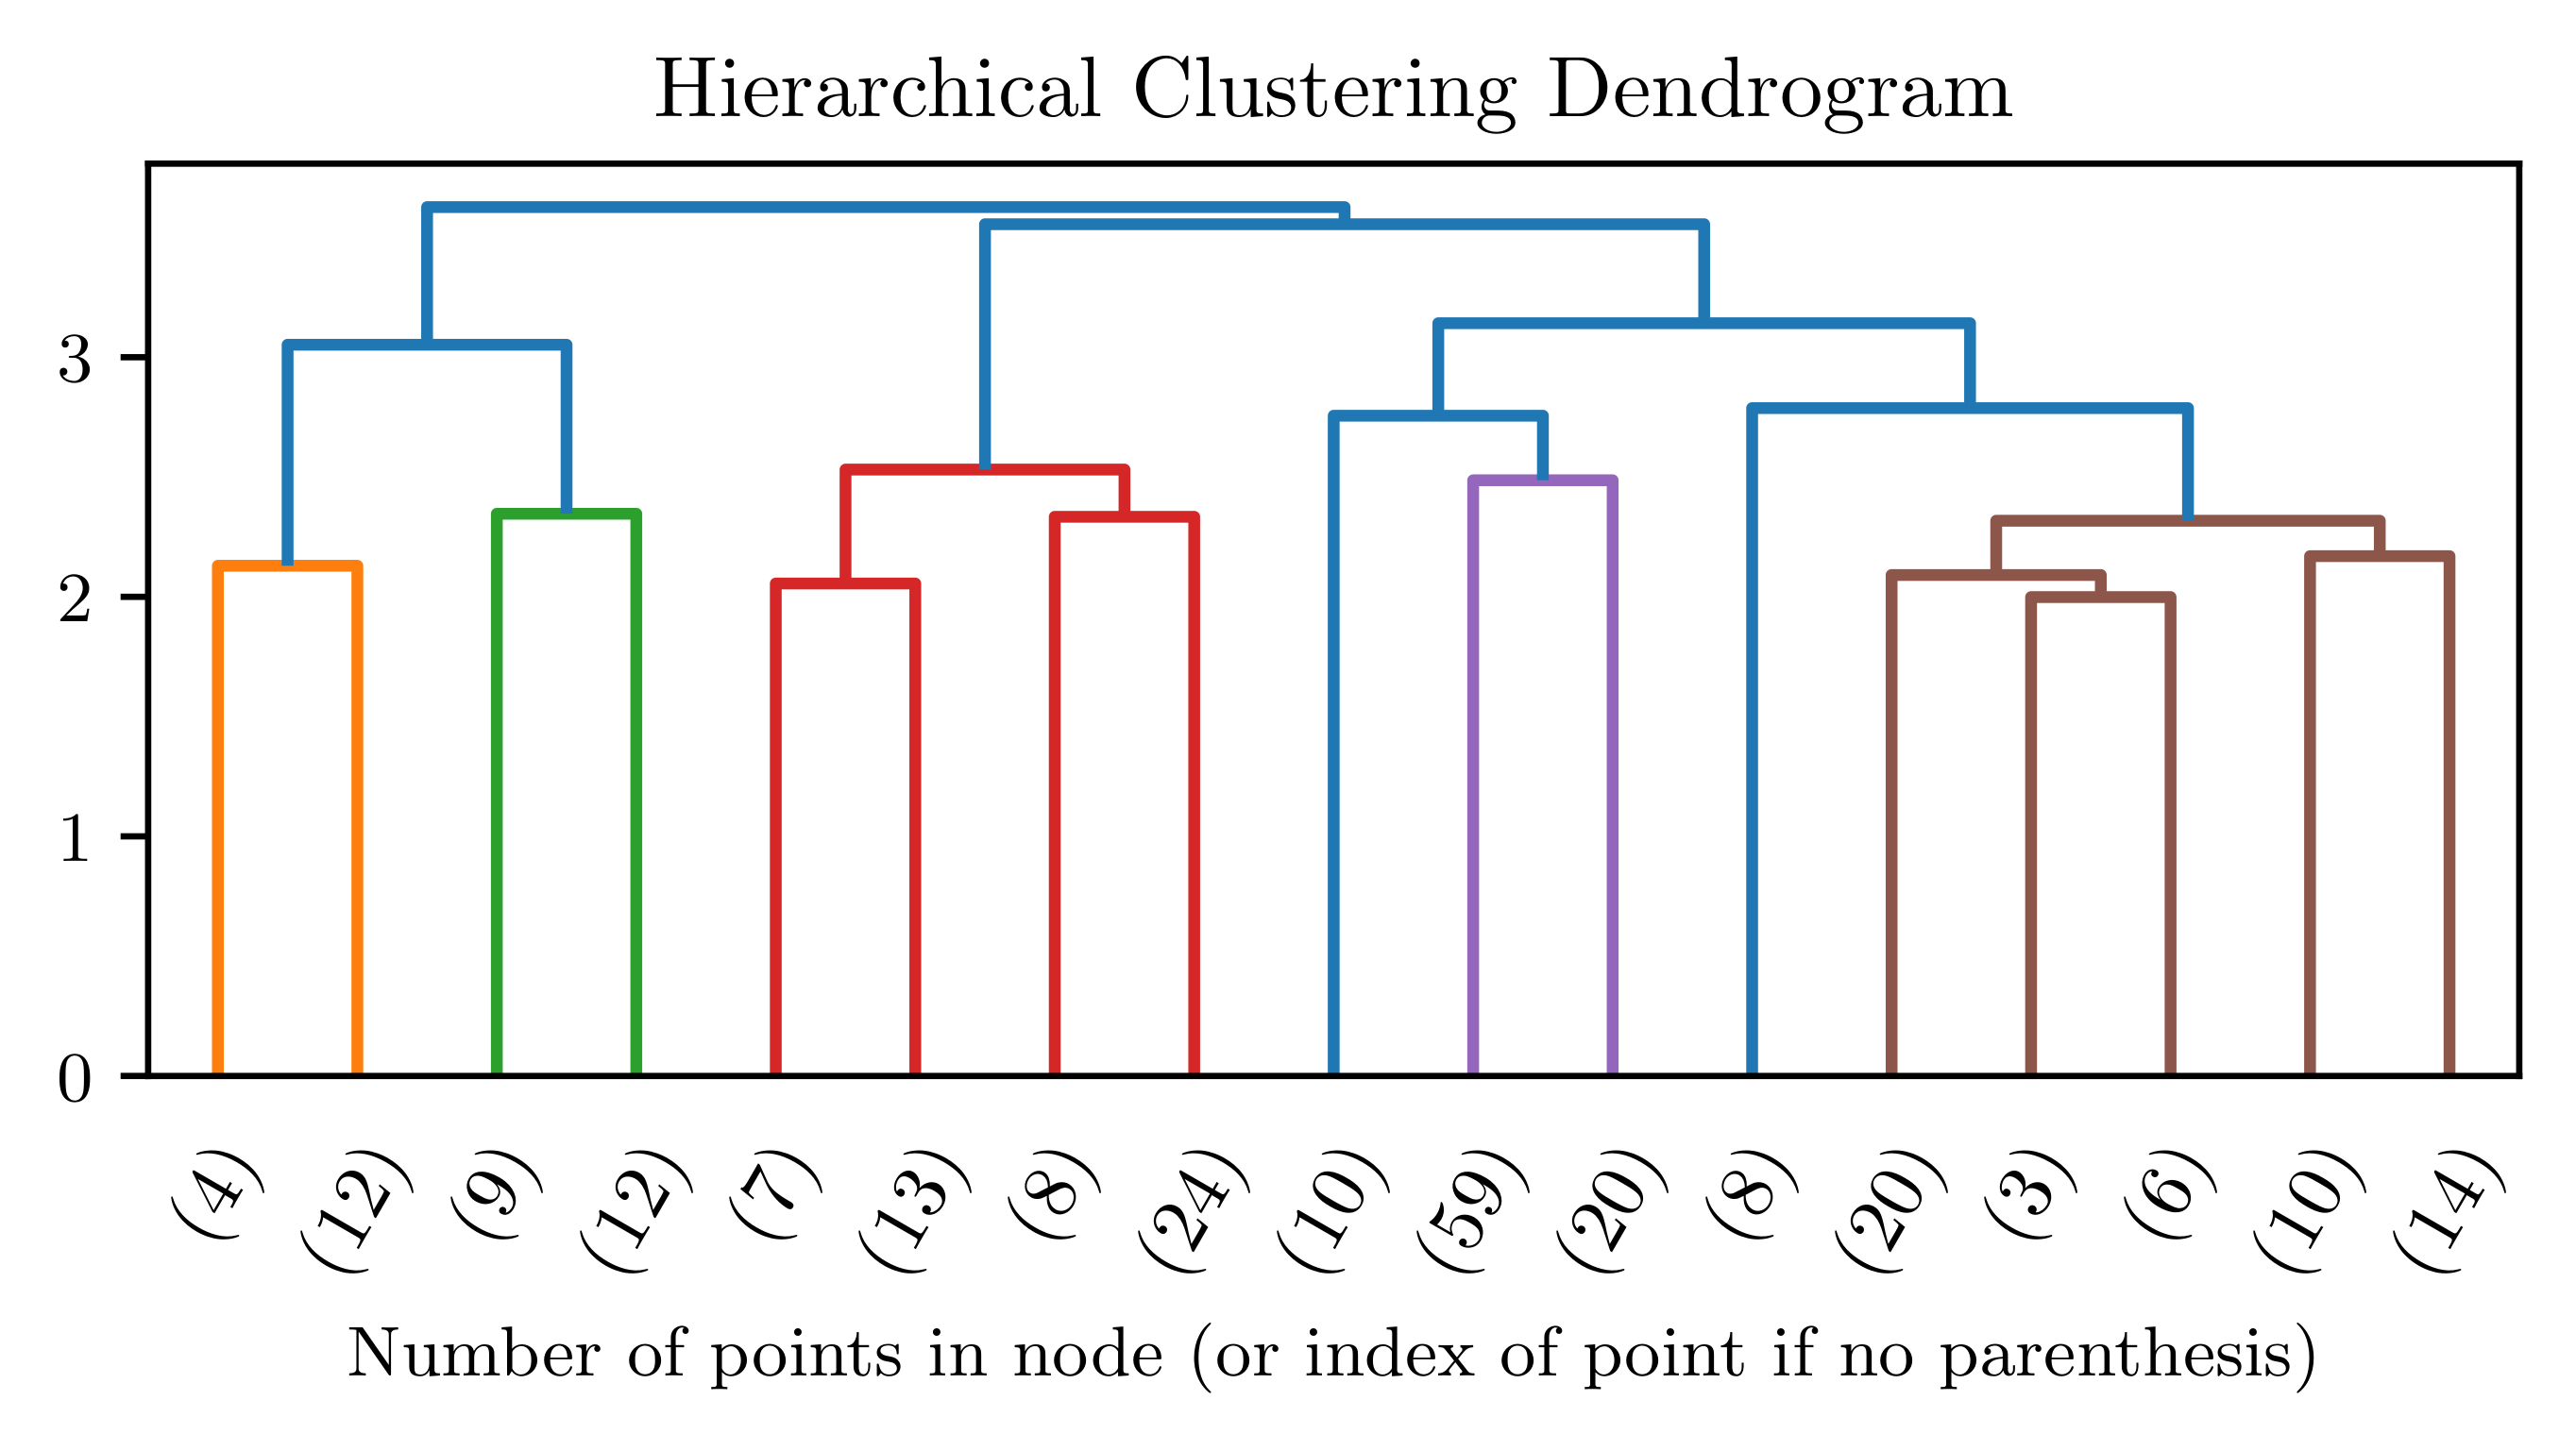

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendo = dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix, dendo

plt.figure(figsize=(3240/600, 1280/600), dpi=600)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram

p = max(clusterDF['cluster'])
#p = 11
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_rotation=60.,leaf_font_size=10.)
#linkageMatrix, dendoPlot = plot_dendrogram(model, leaf_rotation=60.,leaf_font_size=3.)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/denogrammClusteringRaw.png', dpi=600, bbox_inches = 'tight')
#print(dendoPlot["leaves"])

label = fcluster(linkageMatrix, p, criterion='maxclust')

#print(label)

d = {'primitive': clusteredEmb["primitive"].to_list(), 'label':label}
#print(d)

hierarchies = pd.DataFrame(d)

#print(hierarchies)


In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# group by "X" column
groups = hierarchies.groupby('label')

labels = []
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words = stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('all-mpnet-base-v2')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)


    
    labels.append(matchedKeywords)

    # put keywords on the hierechical clustering

print(labels)

GROUP: 1
['hole', 'peg']
hole-peg
GROUP: 2
['driver', 'screwdriver']
driver-screwdriver
GROUP: 3
['grip', 'gripper']
grip-gripper
GROUP: 4
['grab', 'pickup']
grab-pickup
GROUP: 5
['guide', 'spline']
guide-spline
GROUP: 6
['position', 'ptp']
position-ptp
GROUP: 7
['turn', 'flip']
turn-flip
GROUP: 8
['arm', 'hand']
arm-hand
GROUP: 9
['drive', 'pick']
drive-pick
GROUP: 10
['leave', 'remove']
leave-remove
GROUP: 11
['press', 'push']
press-push
GROUP: 12
['colour', 'compare']
colour-compare
GROUP: 13
['inspect', 'quality']
inspect-quality
GROUP: 14
['spray', 'paint']
spray-paint
GROUP: 15
['maintenance', 'service']
maintenance-service
GROUP: 16
['compliant', 'control']
compliant-control
GROUP: 17
['pick', 'place']
pick-place
['hole-peg', 'driver-screwdriver', 'grip-gripper', 'grab-pickup', 'guide-spline', 'position-ptp', 'turn-flip', 'arm-hand', 'drive-pick', 'leave-remove', 'press-push', 'colour-compare', 'inspect-quality', 'spray-paint', 'maintenance-service', 'compliant-control', 'pick-p